In [1]:
import zipfile
import os
import subprocess
import shutil
import sys
home_directory = os.getcwd()

if not os.path.exists('cocoapi'):
    try:
        git_clone3 = '''
                    git clone https://github.com/cocodataset/cocoapi.git
                    '''
        subprocess.run([git_clone3], check=True, shell=True)
        
        os.chdir('cocoapi/PythonAPI')
        
        subprocess.run(['make'], check=True, shell=True)

        os.chdir(home_directory)
    except:
        print('cocoapi repo no se pudo clonar e instalar')
else:        
    try:
        os.chdir('cocoapi/PythonAPI')
        subprocess.run(['make'], check=True, shell=True)
        os.chdir(home_directory)
    except:
        print('no se instaló cocoapi')
        
sys.path += [home_directory+'/cocoapi/PythonAPI']      
from pycocotools.coco import COCO
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pycocotools.coco import COCO
from PIL import Image
import matplotlib.patches as patches


if not os.path.exists('PubLayNet'):
    try:
        git_clone = '''
                    git clone https://github.com/ibm-aur-nlp/PubLayNet.git
                    '''
        subprocess.run([git_clone], check=True, shell=True)
    except:
        print('PubLayNet repo no se pudo clonar')

if not os.path.exists('detectron2'):
    try:
        git_clone = '''
                    git clone https://github.com/facebookresearch/detectron2.git
                    '''
        subprocess.run([git_clone], check=True, shell=True)
    except:
        print('Detectron repo no se pudo clonar')

## Instala detectron2
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'     
    
    
# Añadimos las librerías al PYTHONPATH 
sys.path += [home_directory+'/PubLayNet',home_directory+'/detectron2']
            
## Descargamos el modelo pre-entrenado por PubLayNet
# ! wget https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/pre-trained-models/Faster-RCNN/model_final.pkl -P /home/ec2-user/SageMaker/ocr

## Descargamos una pequeña muestra del dataset (porque son ~50 GB; https://doc-analysis.github.io/docbank-page/index.html):
# ! wget https://layoutlm.blob.core.windows.net/docbank/dataset/DocBank_500K_ori_img.zip.001
## Como solo es una parte del zip, usamos unar para unzipear
# ! sudo apt install unar
# ! unar DocBank_500K_ori_img.zip

## Descargamos las anotaciones y unzipeamos
# ! wget https://layoutlm.blob.core.windows.net/docbank/dataset/MSCOCO_Format_Annotation.zip

## Descargamos el zip adicional del dataset:
# ! wget https://layoutlm.blob.core.windows.net/docbank/dataset/DocBank_500K_txt.zip

#~~~~ REINICIA EL KERNEL DESPUÉS DE LAS INSTALACIONES ~~~~~

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.10 ; cuda:  1.10.0
detectron2: 0.6


In [15]:
'''
Hay que organizar las imágenes en train - val - test
Además hay que borrar las anotaciones de las imágenes que no hemos descargado.
Solo hemos descargado 5GB de 50GB para acelerar el proceso. 
En un escenario real, se entrenaría con todos los datos disponibles.
También serían categorías distintas específicas a nuestros documentos:
nombre, DNI, salario anual, etc. 
'''

train_json_annotations = home_directory + '/coco_annotations/500K_train.json'
val_json_annotations = home_directory + '/coco_annotations/500K_valid.json'
test_json_annotations = home_directory + '/coco_annotations/500K_test.json'

with open(train_json_annotations) as ann:
    train_raw_json = json.load(ann)
    
with open(val_json_annotations) as ann:
    val_raw_json = json.load(ann)

with open(test_json_annotations) as ann:
    test_raw_json = json.load(ann)
    
train_df_images = pd.DataFrame(train_raw_json['images'])
train_img_list = train_df_images.file_name.tolist()

val_df_images = pd.DataFrame(val_raw_json['images'])
val_img_list = val_df_images.file_name.tolist()

test_df_images = pd.DataFrame(test_raw_json['images'])
test_img_list = test_df_images.file_name.tolist()

# total_img_list = os.listdir(home_directory+'/data/DocBank_500K_ori_img')
total_img_list = os.listdir(home_directory+'/data/total')

s_total = set(total_img_list)
s_test = set(test_img_list)
s_val = set(val_img_list)
s_train = set(train_img_list)

train_in_total = list(s_total.intersection(s_train))
val_in_total = list(s_total.intersection(s_val))
test_in_total = list(s_total.intersection(s_test))

print('Train: {}, Val: {}, Test: {}'.format(len(train_in_total), len(val_in_total), len(test_in_total)))

# Es una buena proporción 80% Train, 10% Val, 10% Test
# Train: 42356, Val: 5352, Test: 5276

In [5]:
'''
Ahora vamos a rehacer las anotaciones, para que solo contengan las imágenes
con las que nos hemos quedado
'''

for sample in ['train', 'val', 'test']:
    
    new_dict = {}
    
    dir_sample = home_directory + '/data/' + sample
    if not os.path.exists(dir_sample):
        os.mkdir(dir_sample)
    
    if sample == 'train':
        raw_json = train_raw_json.copy()
        downloaded_images = train_in_total.copy()
    if sample == 'val':
        raw_json = val_raw_json.copy()
        downloaded_images = val_in_total.copy()
    if sample == 'test':
        raw_json = test_raw_json.copy()
        downloaded_images = test_in_total.copy()
        
    df_images = pd.DataFrame(raw_json['images'])
    
    df_images = df_images[df_images.file_name.isin(downloaded_images)]
    df_annotations = pd.DataFrame(raw_json['annotations'])
    df_annotations['area'] = df_annotations['area'].astype('int')

    new_dict['info'] = raw_json['info']
    new_dict['licenses'] = raw_json['licenses']
    new_dict['categories'] = raw_json['categories']
    
    new_dict['annotations'] = df_annotations[df_annotations.image_id.isin(df_images.id.tolist())].to_dict('records')
    new_dict['images'] = df_images.to_dict('records')
    
    with open(home_directory + '/coco_annotations/annotation_{}.json'.format(sample), 'w') as saved_json:
        json.dump(new_dict, saved_json)
        
    # Mueve las imágenes a la carpeta que le corresponde
    for i in downloaded_images:
        source = home_directory + '/data/total/' + i
        destination = home_directory + '/data/' + sample + '/' + i
        if os.path.exists(source):
            shutil.move(source, destination)

In [8]:
## Categorías de mi dataset
train_df_categories = pd.DataFrame(train_raw_json['categories'])
train_df_categories

,id,name,supercategory
0,1,paragraph,
1,2,section,
2,3,caption,
3,4,equation,
4,5,figure,
5,6,date,
6,7,abstract,
7,8,author,
8,9,title,
9,10,table,


In [18]:
# Este es el label map de PubLayNet, un modelo ya pre-entrenado en documentos,
# al final no lo utilizamos.

#~~~~~~~~~~~~~~~~~~~~~~
# Category id -- Label
#~~~~~~~~~~~~~~~~~~~~~~
# 0 -- Background
# 1 -- Text
# 2 -- Title
# 3 -- List
# 4 -- Table
# 5 -- Figure

# # Hay que convertir el modelo para el "label map" de nuestro dataset
# # El 'lookup_table' contiene las clases para las cuales hay que inicializar los pesos (-1)
# # y las clases que comparte el dataset de entreno con el modelo pre-entrenado

# if not os.path.exists('/home/ec2-user/SageMaker/ocr/converted_model/model_final.pkl'):
#     try:
#         convert_model = '''
#                         python PubLayNet/pre-trained-models/convert_PubLayNet_model.py \
#                             --PubLayNet_model /home/ec2-user/SageMaker/ocr/model_final.pkl \
#                             --lookup_table '[-1, -1, -1, 3, -1, -1, 5, -1, -1, 4, 2, -1, -1]' \
#                             --output /home/ec2-user/SageMaker/ocr/converted_model/model_final.pkl
#                         '''
#         subprocess.run([convert_model], check=True, shell=True)
#     except:
#         print('PubLayNet no se pudo convertir')
    
# ## Cambiamos el fichero de configuración elegido para que coja los pesos del modelo pre-entrenado
# # --> faster_rcnn_R_50_C4_3x.yaml

In [5]:
'''
Queremos ejecutar detectron sobre un dataset custom, con el formato de anotaciones COCO.
Registramos el dataset.
'''

from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/home/ec2-user/SageMaker/ocr/coco_annotations/annotation_train.json", "/home/ec2-user/SageMaker/ocr/data/train")
register_coco_instances("my_dataset_val", {}, "/home/ec2-user/SageMaker/ocr/coco_annotations/annotation_val.json", "/home/ec2-user/SageMaker/ocr/data/val")
register_coco_instances("my_dataset_test", {}, "/home/ec2-user/SageMaker/ocr/coco_annotations/annotation_test.json", "/home/ec2-user/SageMaker/ocr/data/test")

[09/04 15:50:24 d2.data.datasets.coco]: Loading /home/ec2-user/SageMaker/ocr/coco_annotations/annotation_train.json takes 4.66 seconds.
[09/04 15:50:24 d2.data.datasets.coco]: Loaded 42355 images in COCO format from /home/ec2-user/SageMaker/ocr/coco_annotations/annotation_train.json


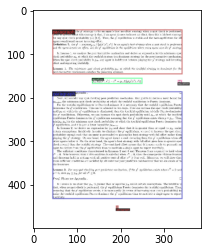

In [19]:
## Visualizamos una o varias imágenes random del entrenamiento
## para comprobar que las anotaciones están bien

mydataset_metadata = MetadataCatalog.get("my_dataset_train")
# classes = MetadataCatalog.get("my_dataset_train").thing_classes
dataset_dicts = DatasetCatalog.get("my_dataset_train")

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=mydataset_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    np_image = vis.get_image()[:, :, ::-1]
    plt.imshow(np_image)
    
    mpimg.imsave(home_directory + '/images/{}'.format(d["file_name"].split('/')[-1]), np_image)

In [21]:
## Épocas es el número de veces que el modelo va a ver el dataset
MAX_ITER = 20000
BATCH_SIZE = 4 # para que no sature la memoria de la GPU
TOTAL_NUM_IMAGES = len(train_in_total)
epoch = MAX_ITER * BATCH_SIZE / TOTAL_NUM_IMAGES
print('Nº épocas: {}'.format(round(epoch)))
## Con muchas corremos el riesgo de overfitting

Nº épocas: 2


In [1]:
## Libera la memoria de la GPU
## En la terminal:
# nvidia-smi
# kill -9 PID_NR

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Que inicialice del model zoo
cfg.SOLVER.IMS_PER_BATCH = BATCH_SIZE
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = MAX_ITER    
cfg.SOLVER.STEPS = []        # sin decay del learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13  # ( https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/29 09:02:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:08, 19.7MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (14, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (14,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (52, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (52,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.

[08/29 09:02:38 d2.engine.train_loop]: Starting training from iteration 0


/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272172048/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/29 09:03:21 d2.utils.events]:  eta: 2:32:51  iter: 19  total_loss: 8.082  loss_cls: 2.807  loss_box_reg: 0.7304  loss_rpn_cls: 4.066  loss_rpn_loc: 0.4689  time: 0.4702  data_time: 0.1889  lr: 4.9953e-06  max_mem: 4325M
[08/29 09:03:29 d2.utils.events]:  eta: 2:28:19  iter: 39  total_loss: 6.008  loss_cls: 2.653  loss_box_reg: 0.7248  loss_rpn_cls: 2.126  loss_rpn_loc: 0.4621  time: 0.4406  data_time: 0.1088  lr: 9.9902e-06  max_mem: 4325M
[08/29 09:03:38 d2.utils.events]:  eta: 2:27:17  iter: 59  total_loss: 3.775  loss_cls: 2.33  loss_box_reg: 0.6473  loss_rpn_cls: 0.5042  loss_rpn_loc: 0.3656  time: 0.4330  data_time: 0.1152  lr: 1.4985e-05  max_mem: 4325M
[08/29 09:03:46 d2.utils.events]:  eta: 2:16:38  iter: 79  total_loss: 3.187  loss_cls: 1.961  loss_box_reg: 0.6376  loss_rpn_cls: 0.1998  loss_rpn_loc: 0.3689  time: 0.4255  data_time: 0.1017  lr: 1.998e-05  max_mem: 4325M
[08/29 09:03:55 d2.utils.events]:  eta: 2:18:20  iter: 99  total_loss: 2.679  loss_cls: 1.434  loss_box_

In [ ]:
## Miramos las curvas de entrenamiento en tensorboard: 
## (No funciona en Sagemaker, por lo que descargo los logs y ejecuto en local)

# %load_ext tensorboard
# %tensorboard --logdir output

In [25]:
## EJECUTAR SI NO VENIMOS DE ENTRENAR EL MODELO:
# from detectron2.engine import DefaultTrainer
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("my_dataset_train",)
# cfg.DATASETS.TEST = ()
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Que inicialice del model zoo
# cfg.SOLVER.IMS_PER_BATCH = BATCH_SIZE
# cfg.SOLVER.BASE_LR = 0.00025  
# cfg.SOLVER.MAX_ITER = MAX_ITER    
# cfg.SOLVER.STEPS = []        # sin decay del learning rate
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13  # ( https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## INFERENCIA
# cambiamos un poco cfg para la inferencia
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path al modelo recién entrenado
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # establecemos un threshold

# Overlap threshold used for non-maximum suppression (suppress boxes with
# IoU >= this threshold)
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6

predictor = DefaultPredictor(cfg)

[09/04 16:03:51 d2.data.datasets.coco]: Loaded 5352 images in COCO format from /home/ec2-user/SageMaker/ocr/coco_annotations/annotation_val.json


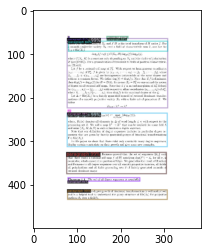

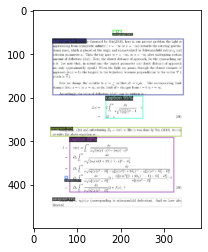

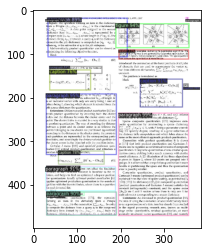

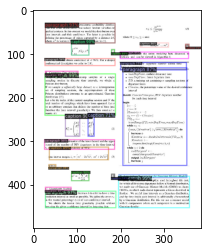

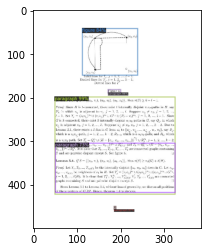

In [27]:
## Predicciones sobre la muestra de validación

from detectron2.utils.visualizer import ColorMode
dataset_dicts_val = DatasetCatalog.get("my_dataset_val")
mydataset_metadata_val = MetadataCatalog.get("my_dataset_val")

for d in random.sample(dataset_dicts_val, 5):    
    im = cv2.imread(d["file_name"])
    img_name = d['file_name'].split('/')[-1].split('jpg')[0]
    outputs = predictor(im)  # https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=mydataset_metadata_val, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    np_image = out.get_image()[:, :, ::-1]
    plt.imshow(np_image)
    mpimg.imsave(home_directory + '/images/{}_pred.jpg'.format(img_name), np_image)
    plt.show()

In [28]:
## Evaluamos la Average Precision (AP)
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[09/04 16:06:12 d2.data.datasets.coco]: Loading /home/ec2-user/SageMaker/ocr/coco_annotations/annotation_val.json takes 1.03 seconds.
[09/04 16:06:12 d2.data.datasets.coco]: Loaded 5352 images in COCO format from /home/ec2-user/SageMaker/ocr/coco_annotations/annotation_val.json
[09/04 16:06:13 d2.data.build]: Distribution of instances among all 13 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| paragraph  | 44316        |  equation  | 12698        |   footer   | 627          |
|  caption   | 2030         |   figure   | 1814         |   table    | 576          |
|  section   | 5586         |    list    | 1079         | reference  | 1307         |
|  abstract  | 403          |   title    | 286          |   author   | 510          |
|    date    | 80           |            |              |            |              |
|   total    | 71312        |       